# Autoencoders

Using device: cpu


100%|██████████| 9.91M/9.91M [00:00<00:00, 11.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 341kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.14MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.28MB/s]


Epoch 1/5, Loss: 0.0279, Avg Encode Time: 0.87 ms, Avg Decode Time: 0.76 ms
Epoch 2/5, Loss: 0.0212, Avg Encode Time: 0.89 ms, Avg Decode Time: 0.78 ms
Epoch 3/5, Loss: 0.0208, Avg Encode Time: 0.87 ms, Avg Decode Time: 0.75 ms
Epoch 4/5, Loss: 0.0174, Avg Encode Time: 0.85 ms, Avg Decode Time: 0.75 ms
Epoch 5/5, Loss: 0.0164, Avg Encode Time: 0.84 ms, Avg Decode Time: 0.74 ms

Overall Average Encode Time: 0.86 ms
Overall Average Decode Time: 0.76 ms


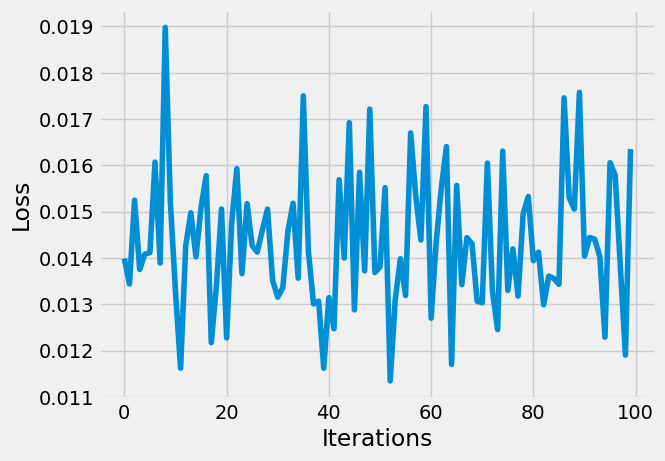


Inference Timing for Visualization Batch:
Encode Time: 0.96 ms
Decode Time: 0.95 ms
Total Inference Time: 1.95 ms


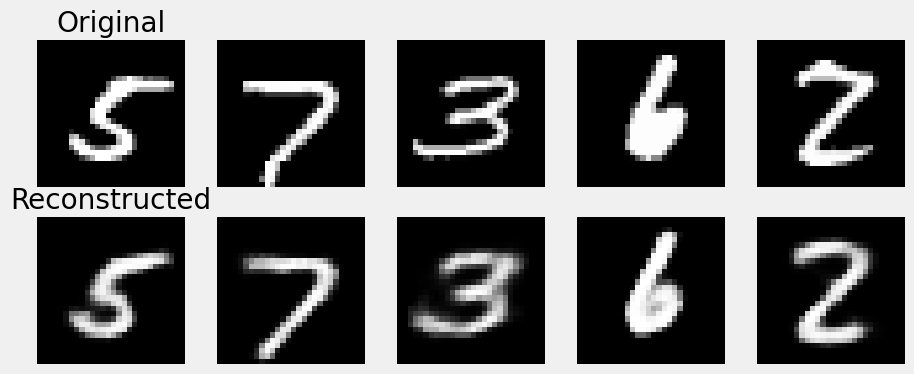

In [ ]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import time

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Transforms images to a PyTorch Tensor
tensor_transform = transforms.ToTensor()

# Download the MNIST Dataset
dataset = datasets.MNIST(root="./data",
                        train=True,
                        download=True,
                        transform=tensor_transform)

# DataLoader to load the dataset
loader = torch.utils.data.DataLoader(dataset=dataset,
                                    batch_size=32,
                                    shuffle=True)

# Define the Autoencoder class
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder: 784 (28*28) -> 256 -> 128 -> 64 -> 16
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 16)
        )

        # Decoder: 16 -> 64 -> 128 -> 256 -> 784 (28*28)
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(16, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 28 * 28),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        # Time the encoding phase
        start_encode = time.perf_counter()
        encoded = self.encoder(x)
        end_encode = time.perf_counter()
        encode_time = end_encode - start_encode

        # Time the decoding phase
        start_decode = time.perf_counter()
        decoded = self.decoder(encoded)
        end_decode = time.perf_counter()
        decode_time = end_decode - start_decode

        return decoded, encode_time, decode_time

# Initialize model, loss function, and optimizer
model = AE().to(device)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop with timing
epochs = 5
losses = []
total_encode_time = 0.0
total_decode_time = 0.0
total_batches = 0

for epoch in range(epochs):
    epoch_encode_time = 0.0
    epoch_decode_time = 0.0
    epoch_batches = 0

    for (image, _) in loader:
        # Move data to GPU
        image = image.reshape(-1, 28*28).to(device)

        # Forward pass with timing
        reconstructed, encode_time, decode_time = model(image)

        # Accumulate times
        epoch_encode_time += encode_time
        epoch_decode_time += decode_time
        total_encode_time += encode_time
        total_decode_time += decode_time
        epoch_batches += 1
        total_batches += 1

        # Compute loss
        loss = loss_function(reconstructed, image)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store loss
        losses.append(loss.item())

    # Average times for the epoch
    avg_encode_time = epoch_encode_time / epoch_batches
    avg_decode_time = epoch_decode_time / epoch_batches
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, '
          f'Avg Encode Time: {avg_encode_time*1000:.2f} ms, '
          f'Avg Decode Time: {avg_decode_time*1000:.2f} ms')

# Overall average times
avg_total_encode_time = total_encode_time / total_batches
avg_total_decode_time = total_decode_time / total_batches
print(f'\nOverall Average Encode Time: {avg_total_encode_time*1000:.2f} ms')
print(f'Overall Average Decode Time: {avg_total_decode_time*1000:.2f} ms')

# Plot the loss
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(losses[-100:])
plt.show()

# Visualize original and reconstructed images with inference timing
with torch.no_grad():  # Disable gradient computation for inference
    # Get a batch of images
    image, _ = next(iter(loader))
    image = image.reshape(-1, 28*28).to(device)

    # Time inference
    start_encode = time.perf_counter()
    reconstructed, encode_time, decode_time = model(image)
    end_decode = time.perf_counter()

    print(f'\nInference Timing for Visualization Batch:')
    print(f'Encode Time: {encode_time*1000:.2f} ms')
    print(f'Decode Time: {decode_time*1000:.2f} ms')
    print(f'Total Inference Time: {(end_decode - start_encode)*1000:.2f} ms')

    # Move data back to CPU for plotting
    image = image.cpu()
    reconstructed = reconstructed.cpu()

    # Plot 5 original vs reconstructed images
    plt.figure(figsize=(10, 4))
    for i in range(5):
        # Original images
        plt.subplot(2, 5, i + 1)
        plt.imshow(image[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Original')

        # Reconstructed images
        plt.subplot(2, 5, i + 6)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Reconstructed')
    plt.show()

# Denoising


Training with Noise Factor: 0.1
Epoch [1/5], Loss: 0.0449
Epoch [2/5], Loss: 0.0319
Epoch [3/5], Loss: 0.0270
Epoch [4/5], Loss: 0.0267
Epoch [5/5], Loss: 0.0207

Training with Noise Factor: 0.5
Epoch [1/5], Loss: 0.0561
Epoch [2/5], Loss: 0.0389
Epoch [3/5], Loss: 0.0319
Epoch [4/5], Loss: 0.0294
Epoch [5/5], Loss: 0.0302

Training with Noise Factor: 0.8
Epoch [1/5], Loss: 0.0566
Epoch [2/5], Loss: 0.0453
Epoch [3/5], Loss: 0.0356
Epoch [4/5], Loss: 0.0367
Epoch [5/5], Loss: 0.0327


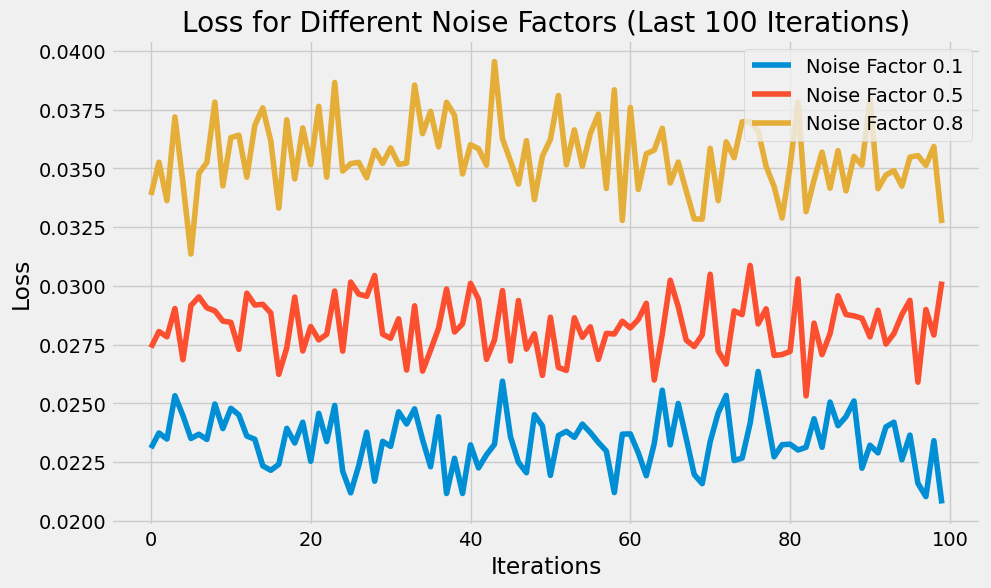


Results for Noise Factor: 0.1


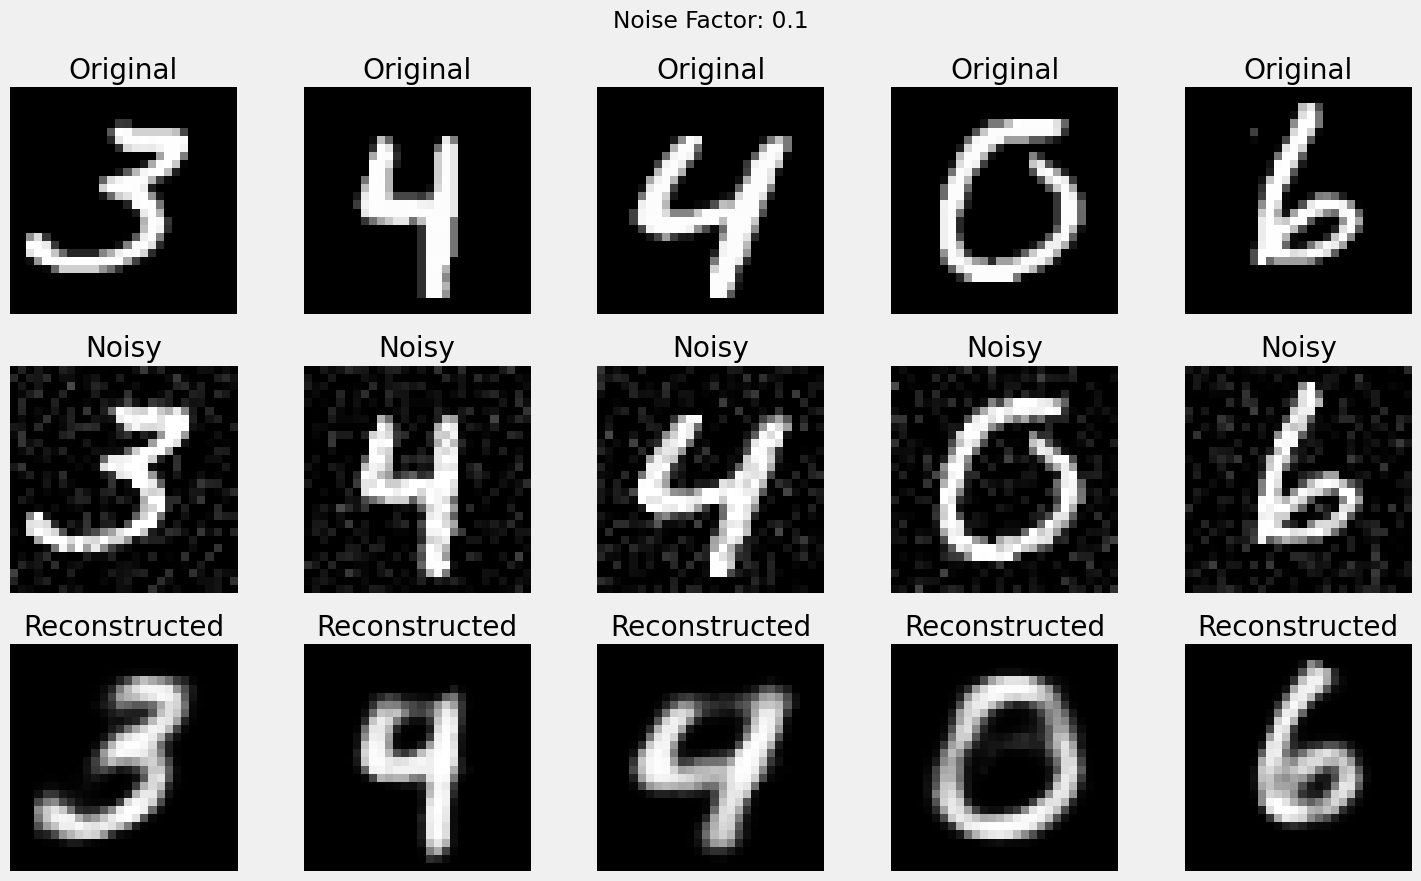


Results for Noise Factor: 0.5


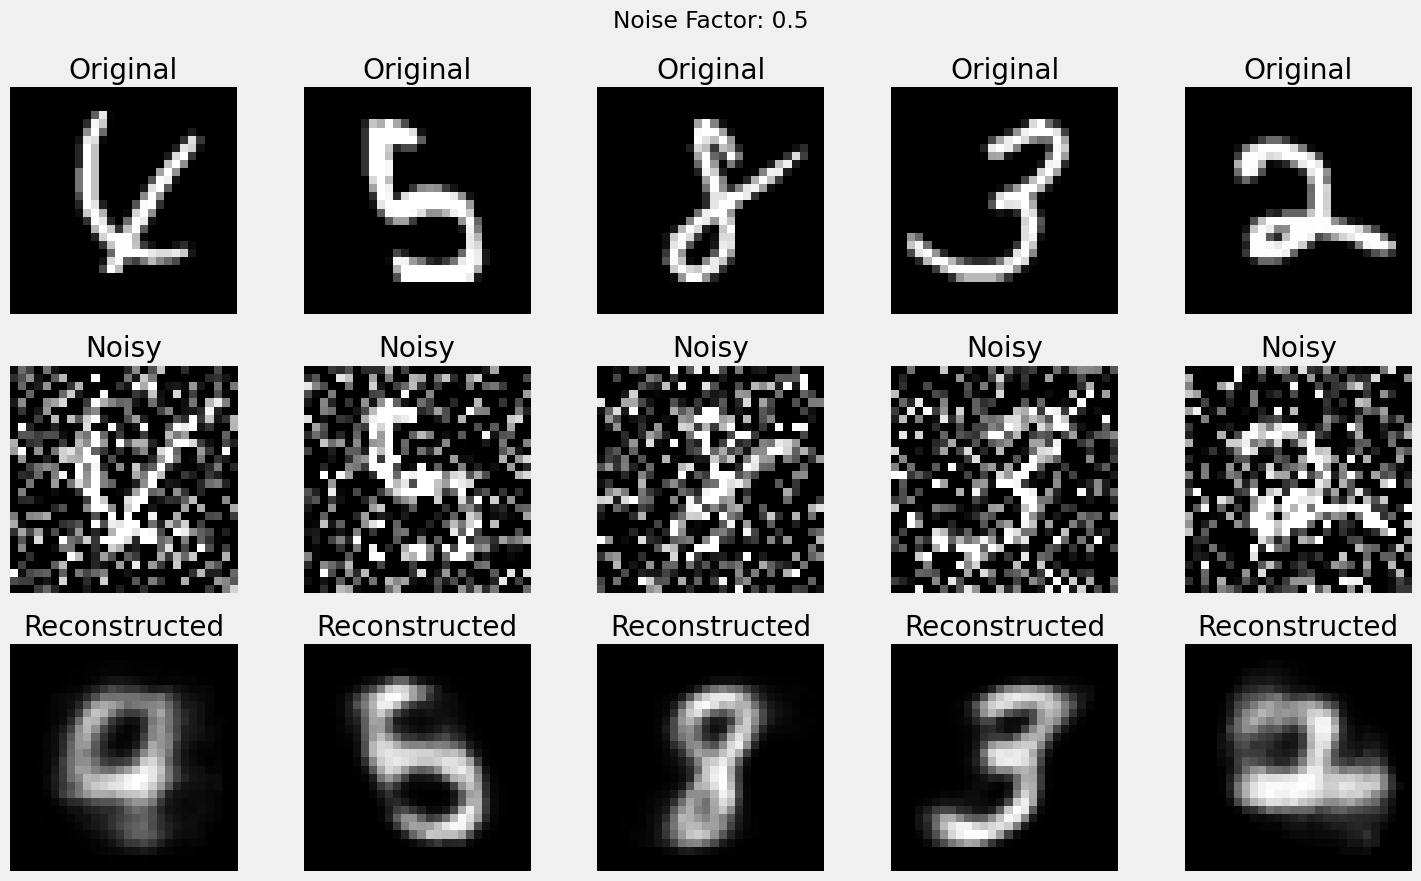


Results for Noise Factor: 0.8


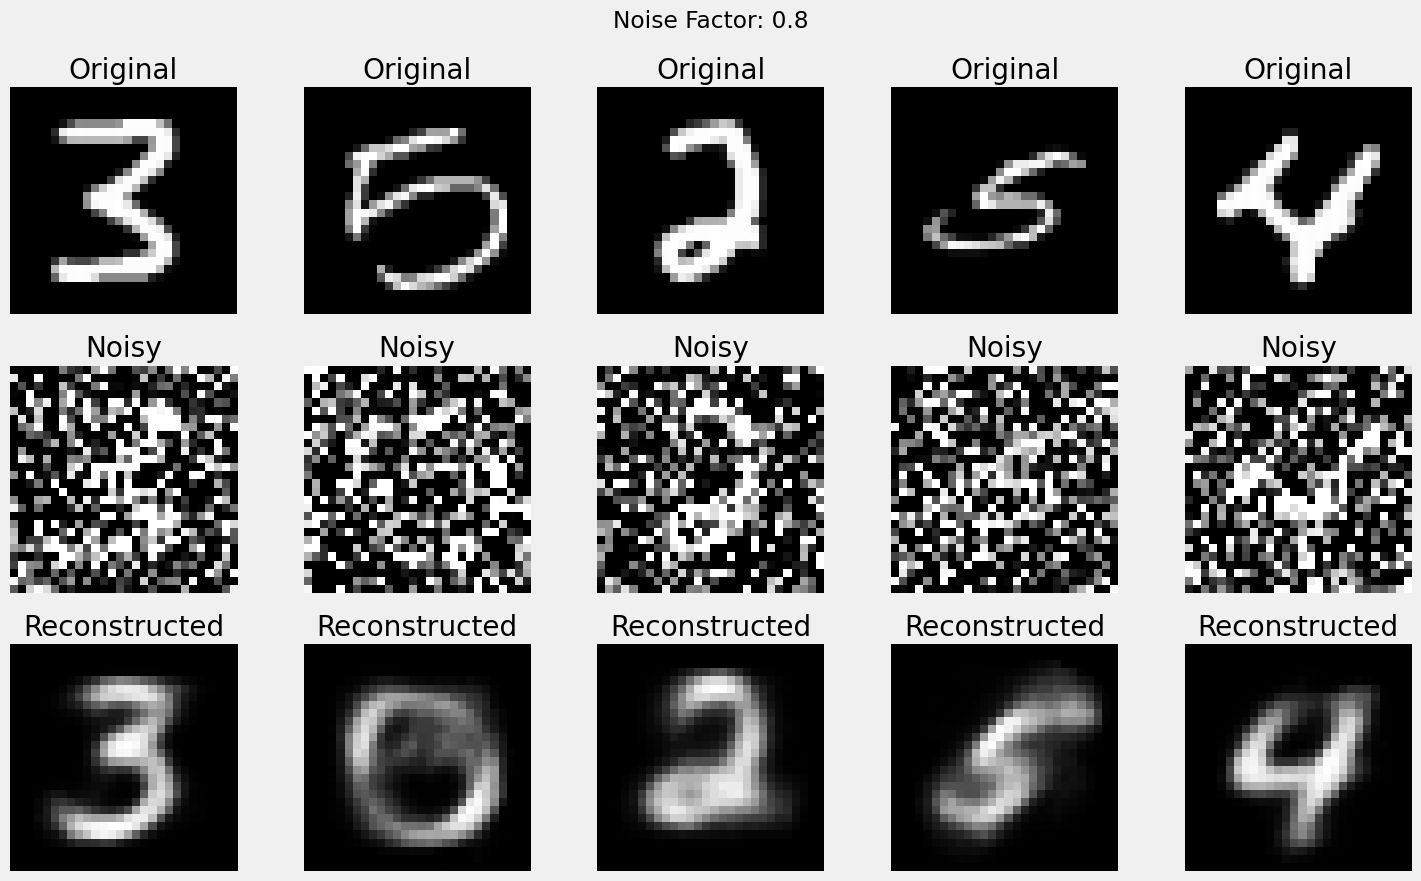

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
input_size = 784  # 28x28 images
num_epochs = 5
batch_size = 128
learning_rate = 0.001
noise_factors = [0.1, 0.5, 0.8]

# MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Denoising Autoencoder model
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        # Encoder: 784 -> 256 -> 128 -> 64 -> 16
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 16),
            nn.ReLU(True)
        )
        # Decoder: 16 -> 64 -> 128 -> 256 -> 784
        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Dictionary to store losses and models for each noise factor
all_losses = {}
all_models = {}

# Train a model for each noise factor
for noise_factor in noise_factors:
    print(f"\nTraining with Noise Factor: {noise_factor}")

    # Initialize model, loss, and optimizer
    model = DenoisingAutoencoder().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    losses = []
    for epoch in range(num_epochs):
        for data in train_loader:
            img, _ = data
            img = img.view(img.size(0), -1).to(device)  # Flatten
            noise = torch.randn(img.shape, device=device) * noise_factor
            noisy_img = img + noise
            noisy_img = torch.clamp(noisy_img, 0., 1.)

            output = model(noisy_img)
            loss = criterion(output, img)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Save model
    torch.save(model.state_dict(), f'denoising_autoencoder_noise_{noise_factor}.pth')

    # Store losses and model
    all_losses[noise_factor] = losses
    all_models[noise_factor] = model

# Plot the loss for each noise factor
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 6))
for noise_factor, losses in all_losses.items():
    plt.plot(losses[-100:], label=f'Noise Factor {noise_factor}')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss for Different Noise Factors (Last 100 Iterations)')
plt.legend()
plt.show()

# Visualize original, noisy, and reconstructed images for each noise factor
for noise_factor in noise_factors:
    print(f"\nResults for Noise Factor: {noise_factor}")

    model = all_models[noise_factor]
    model.eval()
    with torch.no_grad():
        # Get a batch of test images
        dataiter = iter(train_loader)
        images, _ = next(dataiter)
        images = images.view(images.size(0), -1).to(device)

        # Add noise
        noise = torch.randn(images.shape, device=device) * noise_factor
        noisy_images = images + noise
        noisy_images = torch.clamp(noisy_images, 0., 1.)

        # Reconstruct
        reconstructed = model(noisy_images)

        # Move to CPU for plotting
        images = images.view(-1, 28, 28).cpu().numpy()
        noisy_images = noisy_images.view(-1, 28, 28).cpu().numpy()
        reconstructed = reconstructed.view(-1, 28, 28).cpu().numpy()

    # Plotting
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))
    for i in range(5):
        # Original
        axes[0, i].imshow(images[i], cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')

        # Noisy
        axes[1, i].imshow(noisy_images[i], cmap='gray')
        axes[1, i].set_title("Noisy")
        axes[1, i].axis('off')

        # Reconstructed
        axes[2, i].imshow(reconstructed[i], cmap='gray')
        axes[2, i].set_title("Reconstructed")
        axes[2, i].axis('off')

    plt.suptitle(f'Noise Factor: {noise_factor}')
    plt.tight_layout()
    plt.show()